# Creating our own Auto Differentiation (AutoGrad) framework

In this practical exercise we will build our own, very simple, Auto-differentiation (or AutoGrad) framework.

## Coding the framework

### Step 1: Define a class for our variables

The key idea is that we will define our own class of `Variable` which is basically the same as a scalar (a number). So our class is created by passing it a `value`, and it stores this value internally.

But apart from being a placeholder for a number, we also want to keep track of the way every variable was created.

For example, if a variable $c$ is the result of the addition of two variables $a$ and $b$: $c = a + b$, then we would say that $a$ and $b$ are "parent" variables of $c$, and $c$ is their "child". The way $c$ was created was by adding these two parent variables together.

So apart from the value of the variable, we will also have to keep track of the parents, and on how each of them "contributes" to the creation of the variable - this is described by the local derivative associated with each of the parents, that tells us how a change in each of the parent variables translates into a change in the child variable.

This is important in order to implement our backwards pass. Each parent defines a "route" through which the gradients coming into this variable will have to flow through. So we will define a list of `gradRoutes` that will contain the list of parent variables and their corresponding local derivatives. A variable created directly (not resulting by any operation over existing variables) will have an empty `gradRoutes`.

Finally, we want each variable of ours to keep also the value of gradient of the quantity we are interested in with respect to that variable. We will create a placeholder for that as well, called `grad`. As seen before, this will accummulate the gradients that are backpropagated from the children of this variable when we implement the backpropagation algorithm. So we will initialise it to zero.

In [24]:
import numpy as np

In [25]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0        
        
    def __str__(self):
        return 'Value: {self.value}'.format(self=self)        

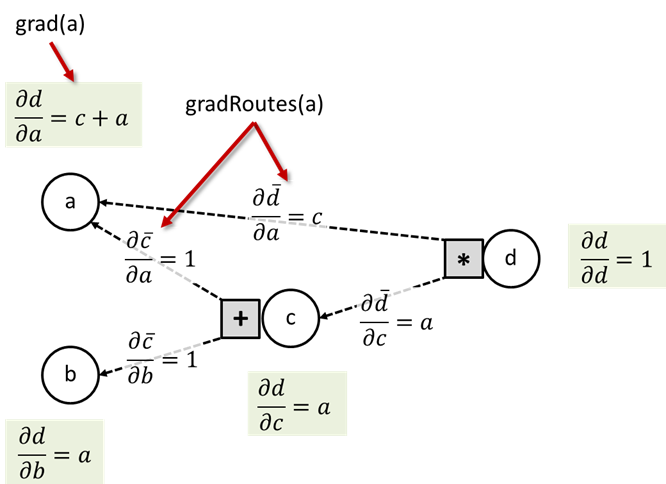

Apart from the `__init__()` function which stores the value passed to our class and initialises the `gradRoutes` and `grad` member variables, we have also overloaded the function that python uses to convert a class into a string representation: `__str__()`. This will allow us to print our class.

We cannot do much yet with this class, apart from storing values into our variables and printing them out. Let's try this out. 

In [26]:
a = Variable(4.3)
b = Variable(5.2)
print(a)
print(b)

Value: 4.3
Value: 5.2


### Step 2: Define operations over our variables

The next step would be to implement operations on our variables. Let's first define the operations for addition and multiplication.

These will be functions that take two variables as input and produce a new (child) variable with a value equal to the sum or the product of the two inputs. Apart from the forward pass though, we should keep track of how this new variable was created: the two parent variables, and their corresponding local derivatives.

In [27]:
def vAdd(A: Variable, B: Variable): # Addition
    result = Variable(A.value + B.value) # Create a new Variable to store the result, and pass it the value = a + b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, 1)) # dresult / dA = 1
    result.gradRoutes.append((B, 1)) # dresult / dB = 1
    
    return result
    
def vMul(A: Variable, B: Variable): # Addition
    result = Variable(A.value * B.value) # Create a new Variable to store the result, and pass it the value = a * b
          
    #keep track of the parent variables, and of the local derivative associated with each one
    result.gradRoutes.append((A, B.value)) # dresult / dA = B
    result.gradRoutes.append((B, A.value)) # dresult / dB = A
    
    return result

So for example to calculate $d = (a + b) * c$ we first need to calculate $(a + b)$ and then mutiply the result with $c$

In [28]:
a = Variable(2) # a = 2
b = Variable(3) # b = 3
c = Variable(4) # c = 4

#d = (a + b) * c = 20
d = vMul(vAdd(a, b), c)

print(d)

Value: 20


### Step 3: Implement the backpropagation function

The final step is to implement the backpropagation function. This starts with a child variable, and backpropagates gradients through the routes defined recursively. It uses the two rules that we saw before:

- Accumulate the incoming gradients from the different grad routes that lead to a node (a variable). Each of the incoming gradients describe a different way in which the node affects the quantity of interest, so this sum will be the final gradient for the node
- Multiply every incoming gradient with each of the local derivatives corresponding to parent variables (this would be the application of the chain rule), and continue the backpropagation through the corresponding route (for each of the parent variables)

We update the `Variable` class accordingly. We also update the `__str___()` function to include also gradient information.

In [29]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val)
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

<font color=blue>**Question:** Why did we set the default value of route_val equal to 1.0?</font>

---

*Answer*


---


This should be all. If we want to calculate the derivative of the result with respect to any of the variables that participated in the calculation, we just need to call backprop on the result, and then read the derivatives out.

In [30]:
a = Variable(2)           # a = 2
b = Variable(3)           # b = 3
c = Variable(4)           # c = 4
res = vMul(vAdd(a, b), c) # res = (a + b) * c = 20

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
print("The derivative of the result with respect to c is:", c.grad)

Result = 20
The derivative of the result with respect to a is: 4.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 5.0


In the following example, variable $a$ affects the result through two different routes

In [31]:
a = Variable(4)  # a = 4
b = Variable(3)  # b = 3
c = vAdd(a, b)   # c = 4 + 3
res = vMul(a, c) # res = a * c = 28

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
# Also for intermediate results
print("The derivative of the result with respect to c is:", c.grad)

Result = 28
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 4.0


<font color=blue>**Question:** Can you now use this setup to calculate the derivative of $c$ with respect to $a$ and $b$?</font>

In [32]:
# Your Code Here


## Final touches

If you understood how this works up to here, then you should be already good to go. But since we want to use our auto grad to do some practical work, we will continue working on it a bit, to make it a bit more usable and complete it with more operations. Many of the subsequent steps are quite "engineering" in nature.

### Improving usability: overloading operators

Of course this is still highly incomplete, very inefficient and not very usable. Lets first improve a usability issue. Instead of having to call different functions for the operations like `res = vMul(a, c)`, we would like to be able to directly write them down like `res = a * b`. To achieve this, we should overload [Python's special functions for operator overloading](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types).

Here's how to do this for the addition and multiplication.

In [1]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0

    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val) 
            
    def __add__(self, b):
        return vAdd(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)            
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

In [34]:
a = Variable(4)  # a = 4
b = Variable(3)  # b = 3
c = a + b        # c = 4 + 3
res = a * c      # res = a * c = 28

print("Result =", res.value)

# Call backprop on the result
res.backProp()

# Now all variables should contain in their "grad" the derivative d(res) / d(variable)
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)
# Also for intermediate results
print("The derivative of the result with respect to c is:", b.grad)

Result = 28
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
The derivative of the result with respect to c is: 4.0


### Zeroing gradients

A last thing to note is that once we call `backProp`, our gradients are calculated and our variables are now "dirty" in the sense that if we call backprop again, the new result will be added to the previous one:

In [35]:
a = Variable(4)   # a = 4
b = Variable(3)   # b = 3
res = (a + b) * a # res = a * c = 28

# Call backprop on the result
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

# Call backprop on the result once more
print("Second time")
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
Second time
The derivative of the result with respect to a is: 22.0
The derivative of the result with respect to b is: 8.0


This will actually turn out to be quite useful, e.g. when we want to accumulate weight gradients over different samples in our learning loops (see next), but we need a way to control it.

To avoid this, we should reset the gradients to zero before we call `backProp` again. We can do it one by one for every variable, but we will also implement a function that does this recursively from the child node we backProped from all the way to the parents.

In [36]:
class Variable: #Simple variable. These are the leafs of our tree, they can request to have a gradient calculated, or not
    def __init__(self, value):
        self.value = value
        self.gradRoutes = [] # A variable by default has no grad Routes (was not created by anything, just defined)
        self.grad = 0.0
    
    def backProp(self, route_val = 1.0):
        # Add together the incoming gradients from the different routes that lead to a node - this will be the final gradient for the node
        self.grad += route_val
                
        # For every parent variable and corresponding local derivative value that we have in the gradRoutes, continue with the gradient calculation
        for variable, local_derivative_value in self.gradRoutes:
            # Multiply the incoming gradient with the local derivatives corresponding the parent variable, and continue the backpropagation
            variable.backProp(local_derivative_value * route_val)

    def zeroGrad(self):
        self.grad = 0.0
        
    def zeroGradsRecursively(self):
        self.zeroGrad()
        for variable, _ in self.gradRoutes:
            variable.zeroGradsRecursively()
            
    def __add__(self, b):
        return vAdd(self, b)
        
    def __mul__(self, b):
        return vMul(self, b)           
    
    def __str__(self):
        return 'Value: {self.value}, Gradient: {self.grad}'.format(self=self)

In [37]:
a = Variable(4)   # a = 4
b = Variable(3)   # b = 3
res = (a + b) * a # res = a * c = 28

# Call backprop on the result
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

# Zero gradients
res.zeroGradsRecursively()

# Call backprop on the result once more
print("Second time")
res.backProp()
print("The derivative of the result with respect to a is:", a.grad)
print("The derivative of the result with respect to b is:", b.grad)

The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0
Second time
The derivative of the result with respect to a is: 11.0
The derivative of the result with respect to b is: 4.0


## More Improvements - Homework

There are number of ways we can improve our simple network. The most important is probably being able to work with vectors and matrices - we will look into this in the next notebook. Before that, there are still a lot of things to do.

---
### <font color=blue>Excercise 1:</font>
    
<font color=blue>We usually do not require gradients for all our variables. If we could indicate which variables require gradients, then we could only keep track of the routes that lead to these variables only and drop all the rest. This would be a huge improvement in resources and speed (number of calculations). Can you add this functionality?</font>

In [38]:
# Your Code Here


---
### <font color=blue>Excercise 2:</font>
    
<font color=blue>We obviously need to implement more functions - implement the following functions:
- Subtraction
- Raising to a power
- Division
- Unary negation
- The (natural) exponential function exp(x)
- ... any other function you might want</font>

In [39]:
# Your Code Here


---
### <font color=blue>Excercise 3:</font>
    
<font color=blue>Our operations currently accept only instances of our Variable class as inputs. So, if you wanted to calculate `a = b * 2` where `b` is an instance of our variable class and `2` is just a numerical constant you would get an error as our framework does not know how to multiply a `Variable` with a number. You should instead write `a = b * Variable(2)` to achieve this.</font>

<font color=blue>Improve further the usability of our framework by allowing our functions to mix numbers and Variables in the same operation (look also into the overloads of the [reflected operands in python](https://docs.python.org/3/reference/datamodel.html#object.__radd__))</font>

In [40]:
# Your Code Here


---
### <font color=blue>Excercise 4:</font>
    
<font color=blue>Instead of keeping track of the local derivative value and doing the multiplication between the local derivative value and the incoming gradient explicitly, it is better to keep track of the actual function used to calculate the local derivative and combine it with the incoming one (the `route_val`). The idea is to keep a note of the recipe for calculating the local derivative value instead of the value itself.</font>

<font color=blue>In our case, since we deal with scalars, this function would basically boil down to doing this multiplication with the `route_val` (applying the chain rule), but when we vectorise our inputs and start dealing with tensors instead of scalars (and `route_val` becomes a matrix), this will become a bit more complicated (a dot product). So, keeping track of the function instead of the local derivative value will allow us to easily extend this framework to this scenario.</font>

<font color=blue>In addition, keeping a note of the function instead of the value, allows us to abstract away stuff. This basically means that we can build the computation graph first, with placeholder variables independently of specific input values, and then reuse it for different inputs. This is how many deep learning frameworks work.</font>

In [41]:
# Your Code Here


---
### <font color=blue>Excercise 5:</font>
    
<font color=blue>Write some code to manually check that your gradient calculation is correct, using the property of:</font>

$$
f'(x) = \frac {f(x+\epsilon) - f(x-\epsilon)}{2 \epsilon}
$$

<font color=blue>where $\epsilon$ is a very small number to approximately calculate the gradient. Then use it to calculate the derivative of the function $f(x) = 21 * x^3$ at $x=3.2$. Double check that our framework gives you the same result.</font>

In [42]:
# Your Code Here
